In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import numpy as np
import math

import torch
import torch.nn as nn
from torch.nn import functional as F

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# не люблю такие названия, но хотел сделать точь-в-точь как в статье, чтобы и мне было удобнее разбираться
def get_data(T=3, n=10_000, S=0.999):
    data = torch.rand(n, T)
    mask = data < S
    data[mask] = 0

    # нормализация
    data = data / torch.norm(data, dim=0, keepdim=True)
    return data


def criterion(x, x_hat):
    return torch.sum((x - x_hat)**2) / x.shape[1]

In [6]:
class ToyModel(nn.Module):
    def __init__(self, n=10_000, m=2):
        super().__init__()
        self.w = nn.Parameter(torch.empty(m, n))
        nn.init.xavier_uniform_(self.w)
        self.b = nn.Parameter(torch.zeros(n, 1))
        
        self.relu = nn.ReLU()

    def forward(self, x, return_hidden_state=False):
        # m n, n T -> m T
        x = self.w @ x
        if return_hidden_state:
            return x
        # n m, m T -> n T
        x = self.w.T @ x + self.b
        x = self.relu(x)
        return x

In [7]:
data = get_data(T=5)
data

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [8]:
model = ToyModel(n=10_000, m=2)

In [9]:
def train(model, data, lr=1e-3, num_steps=50_000, warmup_steps=2_500, device="cpu"):
    model.to(device)
    data = data.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), weight_decay=1e-2)
    # warmup_func = lambda x: x / warmup_steps
    # decay_func = lambda x: 0.5 * (1 + math.cos(math.pi * (x - warmup_steps) / (num_steps - warmup_steps)))
    # lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_func(x) if x <= warmup_steps else decay_func(x))
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        progress = (step - warmup_steps) / (num_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    T = data.shape[1]
    for step in tqdm(range(num_steps), leave=False, desc=f"running for T={T}"):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(data, outputs)
        loss.backward()
        optimizer.step()
        scheduler.step()

    
    torch.save(model.state_dict(), f'models/model_T{T}.pt')
    return model

    # # test
    # test_data = get_data(1000).to(device)
    # with torch.no_grad():
    #     x_hat = model(test_data)
    #     l = loss(test_data, x_hat)
    #     print('test loss', l.item())

In [9]:
train(data, device="cuda")

TypeError: train() missing 1 required positional argument: 'data'

In [10]:
def get_fractional_dimensions(h):
    h_norms = torch.norm(h, dim=0)
    h_unit = h / h_norms
    projections = (h_unit.T @ h) ** 2
    numerators = h_norms ** 2
    denominators = projections.sum(dim=1)
    return (numerators / denominators).tolist()

def plot_vectors(vectors, T, color, prefix):
    vectors = vectors.detach().cpu() if torch.is_tensor(vectors) else vectors
    x, y = vectors[0], vectors[1]

    plt.figure(figsize=(10, 10))
    limit = max(abs(x).max(), abs(y).max())
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)

    plt.plot(x, y, 'o', color=color)
    for xi, yi in zip(x, y):
        plt.plot([0, xi], [0, yi], color=color)

    plt.savefig(f'assets/{prefix}_{T}.png')
    # plt.show()
    plt.close()

def plot_model_features(model, T):
    W = model.w
    plot_vectors(W, T, color='blue', prefix='feats')
    return get_fractional_dimensions(W)

def plot_hidden_states(data, model, T):
    with torch.no_grad():
        h = model(data, return_hidden_state=True)
    plot_vectors(h, T, color='red', prefix='sample')
    return get_fractional_dimensions(h)


In [11]:
ts = [3, 5, 6, 8, 10, 15, 30, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

In [16]:
# def run_experiment(T):
#     train_data = get_data(T=T)
#     model = ToyModel()

#     train(model, train_data, device="cuda")

#     train_data = train_data.to(device)
#     model_features = plot_model_features(model, T)
#     hidden_states = plot_hidden_states(train_data, model, T)
#     return model_features, hidden_states

def run_experiment(T, seed=69):
    torch.manual_seed(seed)
    
    n = 10_000
    train_data = get_data(T=T, n=n)

    test_data = get_data(T=1000, n=n)

    model = ToyModel(n=n)
    device = "cuda"
    train(model, train_data, device=device)

    train_data = train_data.to(device)
    test_data = test_data.to(device)

    model_features = plot_model_features(model, T)
    hidden_states = plot_hidden_states(train_data, model, T)

    with torch.no_grad():
        x_hat = model(test_data)
        loss = criterion(test_data, x_hat)
        print(f'test loss: {loss.item():.6f}')

    return model_features, hidden_states, loss.item()

In [13]:
model_features, hidden_states, loss = run_experiment(3)

running for T=3:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.128925


In [14]:
loss

1.1289252042770386

In [17]:
hidden_dims = []
feat_dims = []
losses = []

for t in tqdm(ts):
    model_features, hidden_states, test_loss = run_experiment(t)
    hidden_dims.append(hidden_states)
    feat_dims.append(model_features)
    losses.append(test_loss)

  0%|          | 0/19 [00:00<?, ?it/s]

running for T=3:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.111024


running for T=5:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.000000


running for T=6:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.000000


running for T=8:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.000000


running for T=10:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.000000


running for T=15:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.100953


running for T=30:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.006797


running for T=50:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.004270


running for T=100:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.001842


running for T=200:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 1.000869


running for T=500:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 2.435149


running for T=1000:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 66.260345


running for T=2000:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 514.331360


running for T=5000:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 289.281036


running for T=10000:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: nan


running for T=20000:   0%|          | 0/50000 [00:00<?, ?it/s]

test loss: 0.998569


running for T=50000:   0%|          | 0/50000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



test loss: nan


running for T=200000:   0%|          | 0/50000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
1

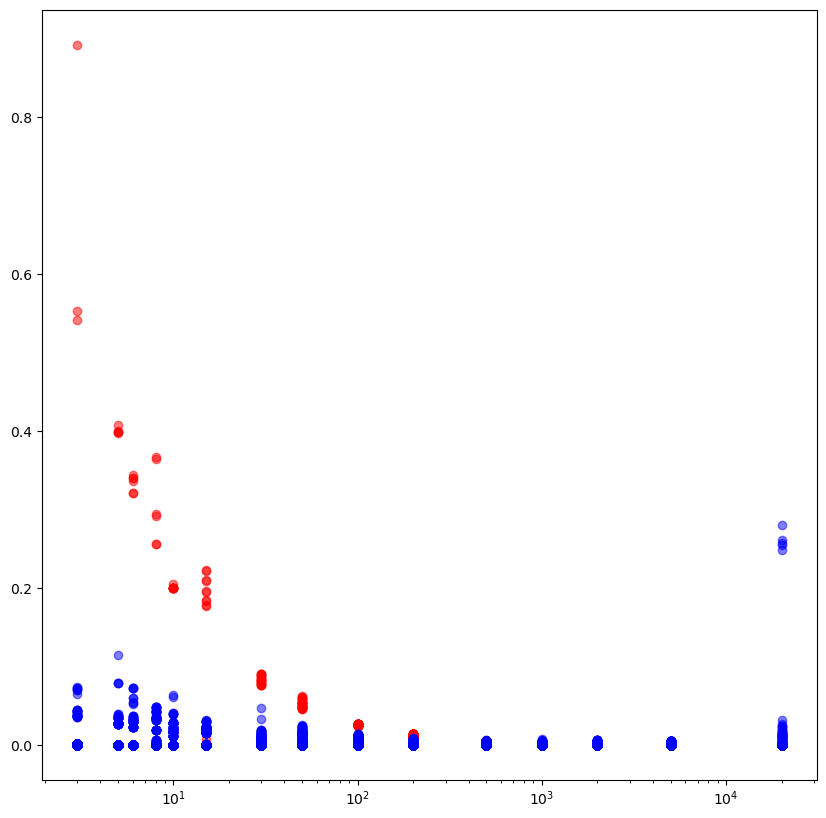

In [18]:
plt.figure(figsize=(10, 10))

for T, h_dim, f_dim in zip(ts, hidden_dims, feat_dims):
    plt.scatter([T]*len(h_dim), h_dim, color='red', alpha=0.5)
    plt.scatter([T]*len(f_dim), f_dim, color='blue', alpha=0.5)

plt.xscale('log')
plt.savefig('dims.png')
plt.show()
plt.close()

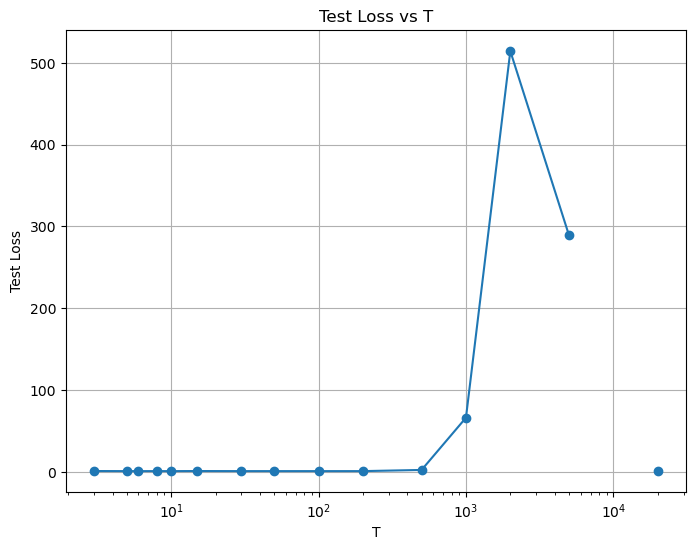

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(ts[:len(losses)], losses, marker='o')
plt.xscale('log')
plt.xlabel('T')
plt.ylabel('Test Loss')
plt.title('Test Loss vs T')
plt.grid(True)
plt.savefig('loss_vs_T.png')
plt.show()
plt.close()
